# **Midterm Project**


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

I first started by preparing and pre-processing a dataset for digit recognition after downloading it from Kaggle. Then I loaded training and test data from CSV files, then separated the class labels from the training data. The training data is split into two sets: 80% for training (X_train_full) and 20% for validation (X_valid). Both the training and test data are normalized by scaling pixel values to a range between 0 and 1. Additionally, the data is reshaped to 4D arrays to accommodate the 28x28 pixel grayscale images.

In [ ]:
digits_train = pd.read_csv('/content/drive/MyDrive/Digit_recognizer_Dataset/train.csv')
digits_test=pd.read_csv('/content/drive/MyDrive/Digit_recognizer_Dataset/test.csv')
X = digits_train.drop(["label"], axis = 1)
y = digits_train["label"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=99)
X_train_full = X_train_full / 255.0
test_df = digits_test / 255.0

X_train = X_train_full.values.reshape(-1,28,28,1)
test_df = digits_test.values.reshape(-1,28,28,1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2,random_state=99)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_full)
X_mean = scaler.mean_
X_std = scaler.scale_

In [ ]:
print("x_train shape",X_train.shape)
print("x_test shape",X_test.shape)
print("x_valid shape",X_valid.shape)

x_train shape (25200, 784)
x_test shape (10500, 784)
x_valid shape (6300, 784)



Then in this stage, I have implemented an efficient input pipeline for managing data in the context of machine learning and deep learning. This pipeline divides the dataset into training, validation, and test sets, saving them in distinct CSV files. Using TensorFlow's tf.data module, the pipeline reads and preprocesses data from these files, incorporating standardization. Shuffling enhances batch randomness, and the prefetch method optimizes performance. This input pipeline simplifies the handling of extensive datasets, minimizes memory utilization, and accelerates model training.

In [ ]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    digits_dir = os.path.join("datasets", "digits")
    os.makedirs(digits_dir, exist_ok=True)
    path_format = os.path.join(digits_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [ ]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = digits_train.columns
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [ ]:
pd.read_csv(train_filepaths[0]).head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [ ]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
n_readers = 10 #size of batch
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # lambda standardization
    cycle_length=n_readers)

In [ ]:
n_inputs = 784 # X_train.shape[-1]
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [ ]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=10,  # number of files at a time
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [ ]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Lambda, Dense, Dropout, Flatten, BatchNormalization

model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(X_train.shape[1:])),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
    ])

early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)


In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy'],
)

In [ ]:
batch_size = 32
history = model.fit(train_set,steps_per_epoch=len(X_train) // batch_size,
                    epochs=35,
                    callbacks = [early_stopping],
                    validation_data = valid_set)

Epoch 1/35
787/787 [==============================] - 17s 21ms/step - loss: 0.2799 - accuracy: 0.9163 - val_loss: 0.1786 - val_accuracy: 0.9462
Epoch 2/35
787/787 [==============================] - 27s 34ms/step - loss: 0.1072 - accuracy: 0.9668 - val_loss: 0.1519 - val_accuracy: 0.9581
Epoch 3/35
787/787 [==============================] - 16s 20ms/step - loss: 0.0709 - accuracy: 0.9776 - val_loss: 0.1574 - val_accuracy: 0.9605
Epoch 4/35
787/787 [==============================] - 16s 20ms/step - loss: 0.0512 - accuracy: 0.9834 - val_loss: 0.1563 - val_accuracy: 0.9606
Epoch 5/35
787/787 [==============================] - 17s 22ms/step - loss: 0.0414 - accuracy: 0.9868 - val_loss: 0.1616 - val_accuracy: 0.9629
Epoch 6/35
787/787 [==============================] - 18s 23ms/step - loss: 0.0450 - accuracy: 0.9864 - val_loss: 0.1716 - val_accuracy: 0.9624
Epoch 7/35
787/787 [==============================] - 18s 22ms/step - loss: 0.0377 - accuracy: 0.9891 - val_loss: 0.1773 - val_accuracy:

In [ ]:
batch_size = 128
score = model.evaluate(test_set, steps=len(X_test) // batch_size)

82/82 [==============================] - 1s 13ms/step - loss: 48.3310 - accuracy: 0.9101


In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 48.330955505371094
Test accuracy: 0.9100610017776489


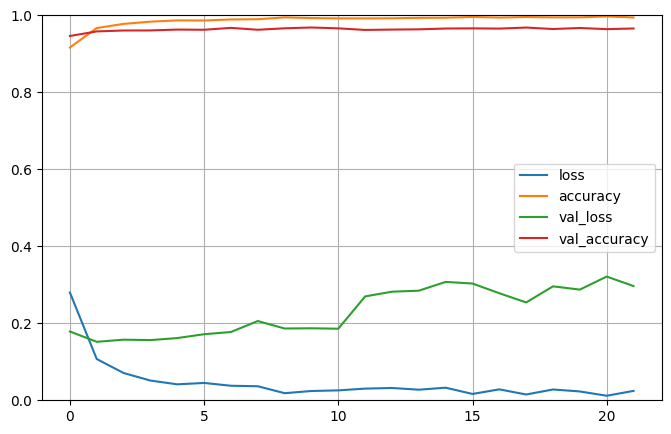

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

I have also introduced a standardization layer to the pipeline to further enhance data preprocessing. This layer computes means and standard deviations from the training data to standardize the features. However, it's worth noting that this model's validation loss remains relatively high despite these efforts

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)
eps = keras.backend.epsilon()

model = keras.models.Sequential([
    keras.layers.Lambda(lambda inputs: (inputs - means) / (stds + eps)),
    keras.layers.Flatten(input_shape=(X_train.shape[1:])),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])



In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
788/788 [==============================] - 8s 9ms/step - loss: 0.3875 - accuracy: 0.8856 - val_loss: 67.7278 - val_accuracy: 0.9475
Epoch 2/30
788/788 [==============================] - 6s 7ms/step - loss: 0.1943 - accuracy: 0.9429 - val_loss: 2.9525 - val_accuracy: 0.9511
Epoch 3/30
788/788 [==============================] - 6s 7ms/step - loss: 0.1599 - accuracy: 0.9543 - val_loss: 61.5959 - val_accuracy: 0.9578
Epoch 4/30
788/788 [==============================] - 5s 7ms/step - loss: 0.1376 - accuracy: 0.9606 - val_loss: 13.3884 - val_accuracy: 0.9575
Epoch 5/30
788/788 [==============================] - 5s 7ms/step - loss: 0.1074 - accuracy: 0.9670 - val_loss: 31.7438 - val_accuracy: 0.9633
Epoch 6/30
788/788 [==============================] - 6s 8ms/step - loss: 0.0994 - accuracy: 0.9712 - val_loss: 6.6463 - val_accuracy: 0.9643
Epoch 7/30
788/788 [==============================] - 5s 7ms/step - loss: 0.0968 - accuracy: 0.9725 - val_loss: 28.2068 - val_accuracy: 0.9659
E

In [ ]:
score = model.evaluate(X_test, y_test)

329/329 [==============================] - 1s 3ms/step - loss: 7385.3857 - accuracy: 0.9036


In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 7385.3857421875
Test accuracy: 0.9036190509796143


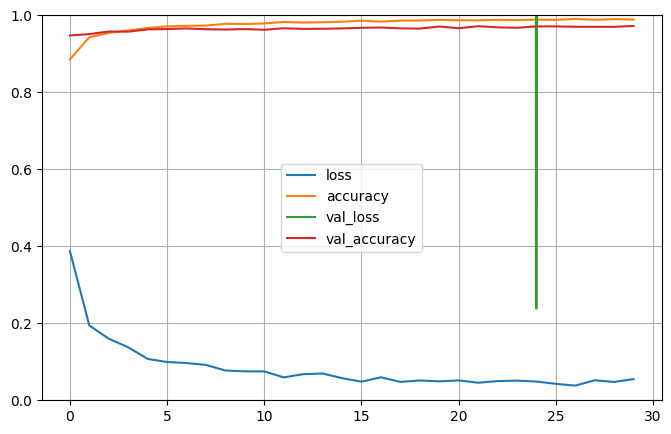

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


Additionally, I have reconfigured the model architecture to incorporate multiple layers and techniques for better model performance. The updated model employs a sequential structure and starts with a flattening layer to transform the input data. It then features several densely connected layers with varying units and activation functions like ReLU. Batch normalization and dropout layers are added to stabilize and regularize the model. These changes aim to improve the model's accuracy and ability to generalize effectively on the data

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(Flatten())
model.add(Dense(units = 8192,activation = 'relu',input_shape=(28, 28)))
model.add(Dense(units = 2048, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = 512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))

early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size = 256,epochs=50,
                    callbacks = [early_stopping],
                    validation_data=(X_valid, y_valid))

Epoch 1/50
99/99 [==============================] - 98s 988ms/step - loss: 0.2978 - accuracy: 0.9102 - val_loss: 0.1997 - val_accuracy: 0.9417
Epoch 2/50
99/99 [==============================] - 113s 1s/step - loss: 0.1664 - accuracy: 0.9498 - val_loss: 0.1569 - val_accuracy: 0.9513
Epoch 3/50
99/99 [==============================] - 119s 1s/step - loss: 0.1140 - accuracy: 0.9644 - val_loss: 0.1842 - val_accuracy: 0.9452
Epoch 4/50
99/99 [==============================] - 98s 995ms/step - loss: 0.0897 - accuracy: 0.9711 - val_loss: 0.1421 - val_accuracy: 0.9576
Epoch 5/50
99/99 [==============================] - 90s 914ms/step - loss: 0.0669 - accuracy: 0.9786 - val_loss: 0.1318 - val_accuracy: 0.9627
Epoch 6/50
99/99 [==============================] - 99s 1s/step - loss: 0.0542 - accuracy: 0.9831 - val_loss: 0.1332 - val_accuracy: 0.9656
Epoch 7/50
99/99 [==============================] - 96s 969ms/step - loss: 0.0460 - accuracy: 0.9844 - val_loss: 0.1105 - val_accuracy: 0.9703
Epoch 

In [ ]:
score = model.evaluate(X_test, y_test)

329/329 [==============================] - 11s 32ms/step - loss: 84.4648 - accuracy: 0.8709


In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 84.46483612060547
Test accuracy: 0.8708571195602417


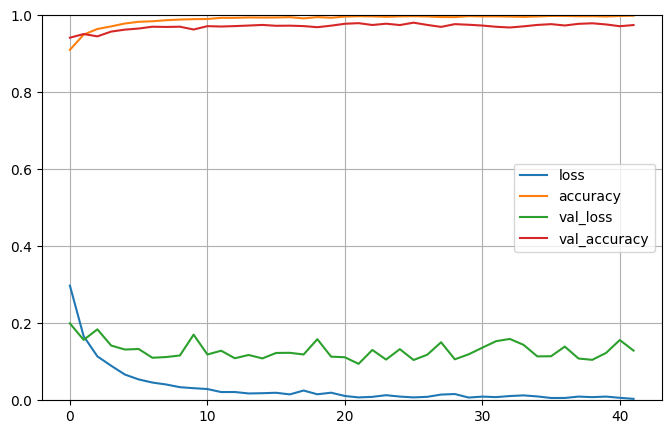

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

I've also experimented with custom activation functions and initializers to further fine-tune the model's performance. Specifically, I implemented a custom Exponential Linear Unit (ELU) activation function, which helps address vanishing gradient issues, and a custom He Normal initializer, which is known for its effectiveness in deep neural networks. These adjustments are aimed at enhancing the model's training and generalization capabilities.

In [ ]:
def custom_elu(x):
    return tf.where(x > 0, x, tf.exp(x) - 1)

In [ ]:
def custom_he_normal(shape, dtype=None):
    stddev = tf.sqrt(2. / shape[-2])
    return tf.random.normal(shape, mean=0.0, stddev=stddev, dtype=dtype)

In [ ]:
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

In [ ]:
def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation=custom_elu, kernel_initializer=custom_he_normal),
    keras.layers.Dense(124, activation=custom_elu,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=custom_he_normal),
    keras.layers.Dense(64, activation=custom_elu,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=custom_he_normal),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size = 64,epochs=50,
                    callbacks = [early_stopping],
                    validation_data=(X_valid, y_valid))

Epoch 1/50
394/394 [==============================] - 3s 5ms/step - loss: 4.0651 - accuracy: 0.7001 - val_loss: 1.5063 - val_accuracy: 0.8462
Epoch 2/50
394/394 [==============================] - 1s 4ms/step - loss: 1.0513 - accuracy: 0.8644 - val_loss: 0.8255 - val_accuracy: 0.8792
Epoch 3/50
394/394 [==============================] - 1s 3ms/step - loss: 0.7455 - accuracy: 0.8869 - val_loss: 0.6804 - val_accuracy: 0.8930
Epoch 4/50
394/394 [==============================] - 1s 3ms/step - loss: 0.6379 - accuracy: 0.8954 - val_loss: 0.6157 - val_accuracy: 0.8992
Epoch 5/50
394/394 [==============================] - 1s 2ms/step - loss: 0.5816 - accuracy: 0.9036 - val_loss: 0.5725 - val_accuracy: 0.9022
Epoch 6/50
394/394 [==============================] - 1s 3ms/step - loss: 0.5419 - accuracy: 0.9094 - val_loss: 0.5468 - val_accuracy: 0.9063
Epoch 7/50
394/394 [==============================] - 1s 3ms/step - loss: 0.5138 - accuracy: 0.9131 - val_loss: 0.5256 - val_accuracy: 0.9103
Epoch 

In [ ]:
score = model.evaluate(test_set, steps=len(X_test) // batch_size)

82/82 [==============================] - 1s 13ms/step - loss: 1095.7107 - accuracy: 0.6139


In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1095.710693359375
Test accuracy: 0.6139481663703918


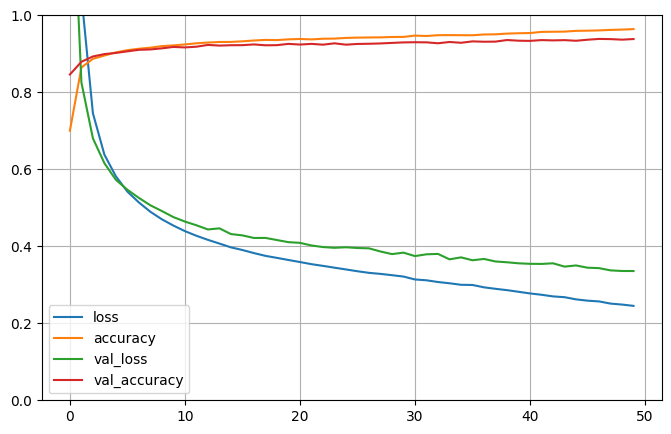

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

I have now implemented a Convolutional Neural Network (CNN) model for image classification, specifically designed for tasks like digit recognition. The code preprocesses and prepares the data, splits it into training and validation sets, defines a CNN architecture, compiles the model, and trains it for 50 epochs. This approach leverages the power of CNNs for image-based tasks.

In [ ]:
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
digits_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
X_train = X / 255.0
test = digits_test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [ ]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y, num_classes = 10)

In [ ]:
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (1,1),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 16, kernel_size = (1,1),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


In [ ]:
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [89]:
history = model.fit(X_train, Y_train, epochs=30, validation_data=(X_val, Y_val))

Epoch 1/30
1182/1182 [==============================] - 158s 133ms/step - loss: 0.4333 - accuracy: 0.8620 - val_loss: 0.0957 - val_accuracy: 0.9714
Epoch 2/30
1182/1182 [==============================] - 157s 133ms/step - loss: 0.1444 - accuracy: 0.9574 - val_loss: 0.0660 - val_accuracy: 0.9783
Epoch 3/30
1182/1182 [==============================] - 158s 134ms/step - loss: 0.1146 - accuracy: 0.9665 - val_loss: 0.0604 - val_accuracy: 0.9821
Epoch 4/30
1182/1182 [==============================] - 155s 131ms/step - loss: 0.1004 - accuracy: 0.9712 - val_loss: 0.0480 - val_accuracy: 0.9862
Epoch 5/30
1182/1182 [==============================] - 156s 132ms/step - loss: 0.0912 - accuracy: 0.9730 - val_loss: 0.0604 - val_accuracy: 0.9821
Epoch 6/30
1182/1182 [==============================] - 156s 132ms/step - loss: 0.0867 - accuracy: 0.9750 - val_loss: 0.0517 - val_accuracy: 0.9852
Epoch 7/30
1182/1182 [==============================] - 154s 130ms/step - loss: 0.0809 - accuracy: 0.9767 - val_

In [93]:
score = model.evaluate(X_val, Y_val)

132/132 [==============================] - 7s 50ms/step - loss: 0.0503 - accuracy: 0.9871


In [94]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05027713254094124
Test accuracy: 0.9871428608894348


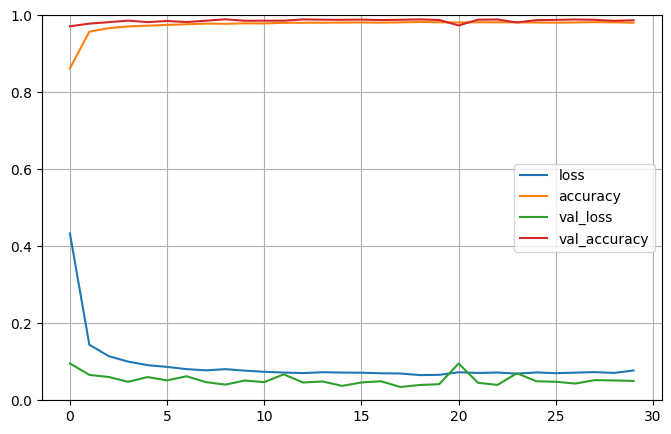

In [95]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

 Finally I was able to achieve 98.7% accuracy for the MNIST Digit Dataset classification task using CNN model.